In [1]:
import numpy as np
from scipy import stats
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
# set seed
np.random.seed(69420)

In [2]:
# Kuhn-Munkres algorithm - aligns unsupervised labels such that the accuracy is maximized with the true label

def align_hard_labels(y_pred, y_true, num_classes):
    cost_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            cost_matrix[i, j] = np.sum((y_pred == i) & (y_true == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    perm = dict(zip(row_ind, col_ind))
    aligned_pred = np.vectorize(lambda x: perm.get(x, x))(y_pred)
    return aligned_pred

In [3]:
# helper function to plot accuracy

def plot_accuracy(y_pred, y_true, num_classes, title="Per-Class Accuracy"):
    accuracies = np.zeros(num_classes)
    
    for cls in range(num_classes):
        idx = (y_true == cls)
        if np.sum(idx) > 0:
            accuracies[cls] = np.mean(y_pred[idx] == y_true[idx])
        else:
            accuracies[cls] = 0.0

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(np.arange(num_classes), accuracies)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.xticks(np.arange(num_classes))
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Unsupervised Classification:
Definition: Given data vectors $\mathbf{x}_1,\mathbf{x}_2,\dots,\mathbf{x}_n\in\mathbb{R}^d$ and a set of possible classes $\mathcal{C}=\{1,2,\dots,k\}$, we attempt to find $z_1,z_2,\dots,z_n\in \mathcal{C}$ and parameters $\theta$ such that $\prod_{i=1}^n \mathbb{P}(\mathbf{x}_i,z_i;\theta)$. In other words, the MLE under a known distribution type is maximized. For this, we generate a set of dummy data using a Gaussian Mixture Model

In [4]:
import numpy as np

def separated_means(n_classes, n_features, min_dist, low=-10, high=10, max_tries=1000):
    mus = []
    tries = 0
    while len(mus) < n_classes and tries < max_tries:
        candidate = np.random.uniform(low, high, size=(n_features,))
        if all(np.linalg.norm(candidate - mu) >= min_dist for mu in mus):
            mus.append(candidate)
        tries += 1
    if len(mus) < n_classes:
        raise ValueError("Fail to generate far enough samples")
    return np.array(mus)


def generate_gmm(n_samples=1000, n_classes=4, n_features=2):
    
    # randomize phi (weights)
    phi = np.random.rand(n_classes)
    phi /= phi.sum()

    # randomize mu (means) that are far apart
    mu = separated_means(n_classes, n_features, min_dist=4.0, low=-20, high=20, max_tries=1000)

    # randomize sigma (covariances)
    sigma = []
    for _ in range(n_classes):
        A = np.random.rand(n_features, n_features)
        cov = np.dot(A, A.T) + np.eye(n_features) * np.random.uniform(0.5,1.5)  # guaranteed positive definite
        sigma.append(cov)

    # sample from GMM
    X = []
    y = []
    for _ in range(n_samples):
        k = np.random.choice(n_classes, p=phi)
        x = np.random.multivariate_normal(mu[k], sigma[k])
        X.append(x)
        y.append(k)

    return np.array(X), np.array(y), mu, sigma, phi

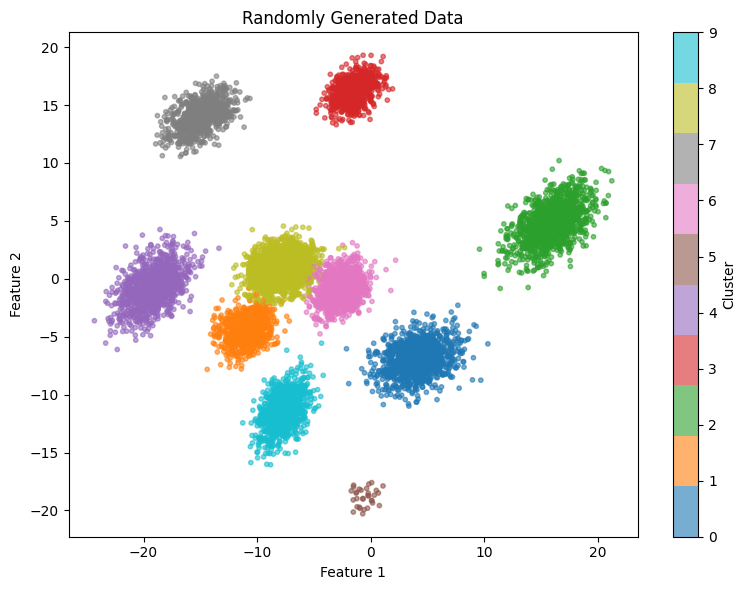

In [5]:
X, y, mu_true, sigma_true, phi_true = generate_gmm(n_samples=10000, n_classes=10, n_features=2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
plt.title("Randomly Generated Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, ticks=range(len(phi_true)), label='Cluster')
plt.tight_layout()
plt.show()

In [25]:
# fixed starting point:
mu0 = X[np.random.choice(10000, 10, replace=False)]

## K-means Algorithm

The K-means clustering finds an estimate to the unsupervised classification problem using the following procedure. First assign centroids $\boldsymbol{\mu}_j^{(0)}$ for $j=\{1,2,\dots,k\}$ to random points. Until convergence, run
- $\mathcal{S}_j^{(t)} = \{i\in\{1,2,\dots,n\}:j=\arg\max_l\|\boldsymbol{\mu}_l^{(t)}-\mathbf{x}_i\|_2^2\}$
- $\boldsymbol{\mu}_j^{(t+1)}=\frac{1}{|\mathcal{S}_j^{(t)}|}\sum_{i\in \mathcal{S}_j^{(t)}} \mathbf{x}_i$
Finally, assign $\hat{z}_i=\arg\min_j\|\boldsymbol{\mu}_j^{(t)}-\mathbf{x}_i\|_2^2$.

We implemented the K-means training and testing algorithm down below:

In [26]:
def k_means(X, k, mu0, max_iter=100, tol=1e-4):
    # Step 1: Initialize mu 0 to random points. Here, we initialize them as k random points from the dataset
    mu = mu0

    for t in tqdm(range(max_iter)):
        # Step 2: Compute the distance |mu^t_j-x_i| and finally compute S_t
        distances = np.linalg.norm(X[:, np.newaxis] - mu, axis=2)
        S_t = np.argmin(distances, axis=1)

        # Step 3: Compute mu^(t+1)
        mu_new = np.array([
            X[S_t == j].mean(axis=0) if np.any(S_t == j) else centroids[j]
            for j in range(k)
        ])

        # Optional, check if the centroids has moved enough
        if np.linalg.norm(mu_new - mu) < tol:
            break

        mu = mu_new

    # Return: assignment and centroids
    return np.argmin(np.linalg.norm(X[:, np.newaxis] - mu, axis=2), axis=1), mu

In [27]:
y_pred, mu = k_means(X, 10, mu0, max_iter=1000, tol=1e-6)

  2%|▏         | 20/1000 [00:00<00:09, 100.96it/s]


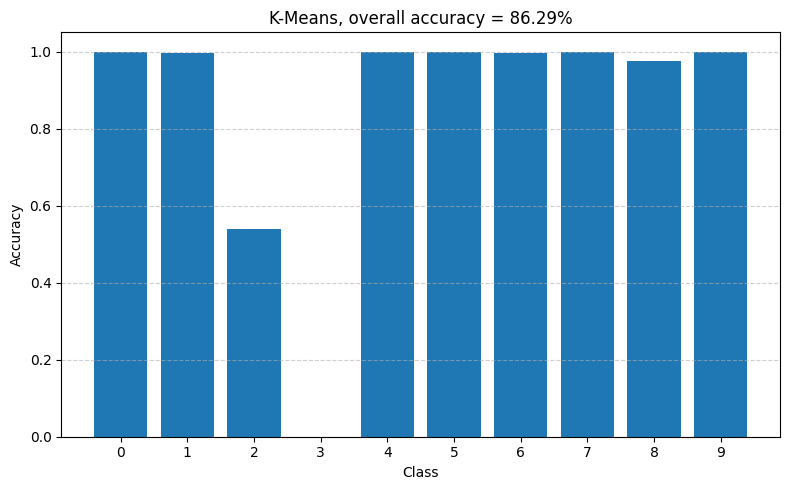

In [28]:
y_pred = align_hard_labels(y_pred, y, 10)
acc = np.sum(y_pred == y)/len(y)

plot_accuracy(y_pred, y, 10, title=f"K-Means, overall accuracy = {round(acc*100,2)}%")

Visualizing the predicted clusters as well as its means

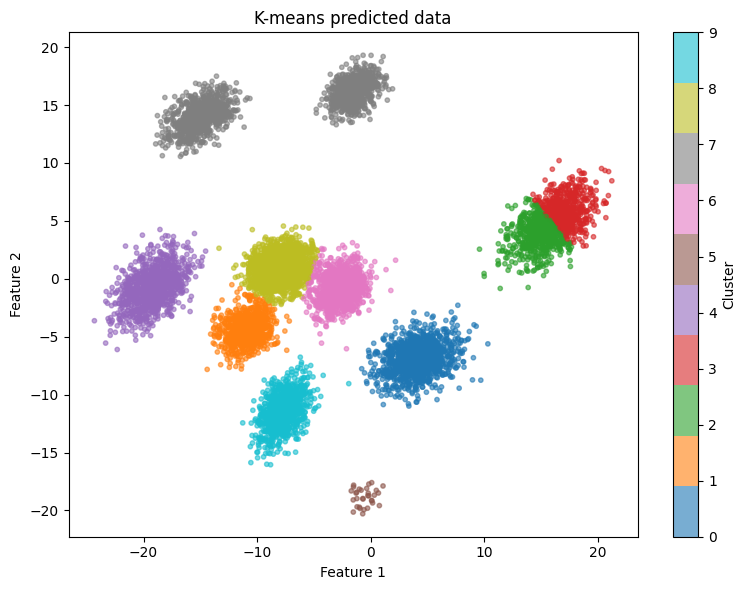

In [29]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', alpha=0.6, s=10)
plt.title("K-means predicted data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, ticks=range(len(phi_true)), label='Cluster')
plt.tight_layout()
plt.show()

## Gaussian Mixture Clustering

Following the EM algorithm:
- **Expectation (E) Step:** $q_i^{(t)}(z)=p(z|\mathbf{x}_i;\theta^{(t)})$ for $i=1,2,\dots,n$
- **Maximization (M) Step:** We first use Bayes's rule to re-write the terms
\begin{align*}
    \theta^{(t+1)} 
    &= \arg\max_{\theta} \sum_{i=1}^n \sum_{z=1}^k q_i^{(t)}(z) \log(p(\mathbf{x}|z;\boldsymbol{\mu}_z,\Sigma_z,\phi_z)) \\
    &= \arg\max_{\theta} \sum_{i=1}^n \sum_{z=1}^k q_i^{(t)}(z) \log\left(\frac{p(\mathbf{x},z;\boldsymbol{\mu}_z,\Sigma_z,\phi_z)}{q_i^{(t)}(z)}\right) \\
    &= \arg\max_{\theta} \sum_{i=1}^n \sum_{z=1}^k q_i^{(t)}(z) \log\left(\frac{p(\mathbf{x}|z;\boldsymbol{\mu}_z,\Sigma_z)p(z,\phi_z)}{q_i^{(t)}(z)}\right) \\
    &= \arg\max_{\theta} \sum_{i=1}^n \sum_{z=1}^k q_i^{(t)}(z) \log\left(\frac{p(\mathbf{x}|z;\boldsymbol{\mu}_z,\Sigma_z)\phi_z}{q_i^{(t)}(z)}\right)
\end{align*}
therefore, taking the log and removing constant terms
$$
\theta^{(t+1)} = \arg\max_{\theta} \sum_{i=1}^n \sum_{z=1}^k q_i^{(t)}(z) 
\left(
    -\frac{n}{2} \log |\Sigma_z|
    - \frac{1}{2} \sum_{i=1}^n (\mathbf{x}_i - \boldsymbol{\mu}_z)^\top \Sigma_z^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_z)
    + \log(\phi_z)
\right)
$$
Notice that the optimization terms for $\boldsymbol{\mu}_z$ and $\Sigma_z$ is a linear combination of several log-likelihood terms of regular Gaussian fitting. Indeed, we are able to use the results from the preface to conclude that for $z=1,2,\dots,k$
$$
\boldsymbol{\mu}_z^{(t)} = \frac{\sum_{i=1}^n q_i^{(t)}(z) \mathbf{x}_i}{\sum_{i=1}^n q_i^{(t)}(z)}
\text{ and }
\Sigma_z^{(t)}  = \frac{\sum_{i=1}^n q_i^{(t)}(z) (\mathbf{x}_i-\boldsymbol{\mu}_z)(\mathbf{x}_i-\boldsymbol{\mu}_z)^\top}{\sum_{i=1}^n q_i^{(t)}(z)}
$$
Furthermore, the optimization terms $\phi_z$ are a linear combination of several log-likelihood terms of the categorical sampling. Similarly, we can use the results the preface to conclude that for $z=1,2,\dots,k$
$$
\phi_z^{(t)}  = \frac{1}{n} \sum_{i=1}^n q_i^{(t)}(z)
$$

In [33]:
def gaussian_mixture_fit(X, k, mu0, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    #  initialize mu, sigma, and phi
    mu = mu0
    sigma = [np.cov(X.T) + np.eye(n_features)*1e-6 for _ in range(k)]
    phi = np.ones(k) / k
    log_likelihood_prev = None

    for _ in tqdm(range(max_iter)):
        # e step, compute q(z)
        qz = np.zeros((n_samples, k))
        for j in range(k):
            rv = stats.multivariate_normal(mean=mu[j], cov=sigma[j])
            qz[:, j] = phi[j] * rv.pdf(X)
        qz = qz / np.sum(qz, axis=1, keepdims=True)

        # m step, update mu, sigma, phi
        N_k = qz.sum(axis=0)
        mu = (qz.T @ X) / N_k[:, np.newaxis]
        sigma = []
        for j in range(k):
            X_centered = X - mu[j]
            weighted_cov = (qz[:, j][:, np.newaxis] * X_centered).T @ X_centered
            cov = weighted_cov / N_k[j] + np.eye(n_features)*1e-6
            sigma.append(cov)
        phi = N_k / n_samples

        # Optional: check convergence with log likelihood (this term is proven to converge)
        log_likelihood = np.sum(np.log(np.sum([
            phi[j] * stats.multivariate_normal(mu[j], sigma[j]).pdf(X) for j in range(k)
        ], axis=0)))
        if log_likelihood_prev is not None and abs(log_likelihood - log_likelihood_prev) < tol:
            break
        log_likelihood_prev = log_likelihood

    return np.argmax(qz, axis=1), (mu, sigma, phi)

In [34]:
y_pred, (mu, sigma, phi) = gaussian_mixture_fit(X, 10, mu0, max_iter=10000, tol=1e-6)

 37%|███▋      | 3691/10000 [00:53<01:31, 69.23it/s]


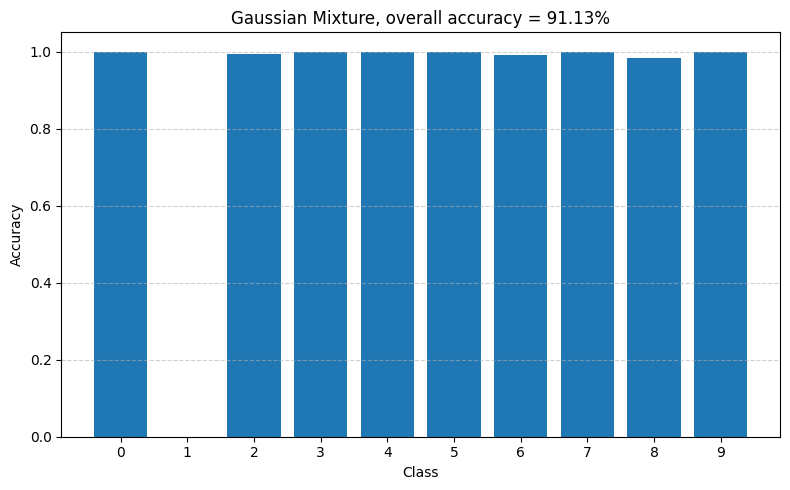

In [35]:
y_pred = align_hard_labels(y_pred, y, 10)
acc = np.sum(y_pred == y)/len(y)

plot_accuracy(y_pred, y, 10, title=f"Gaussian Mixture, overall accuracy = {round(acc*100,2)}%")

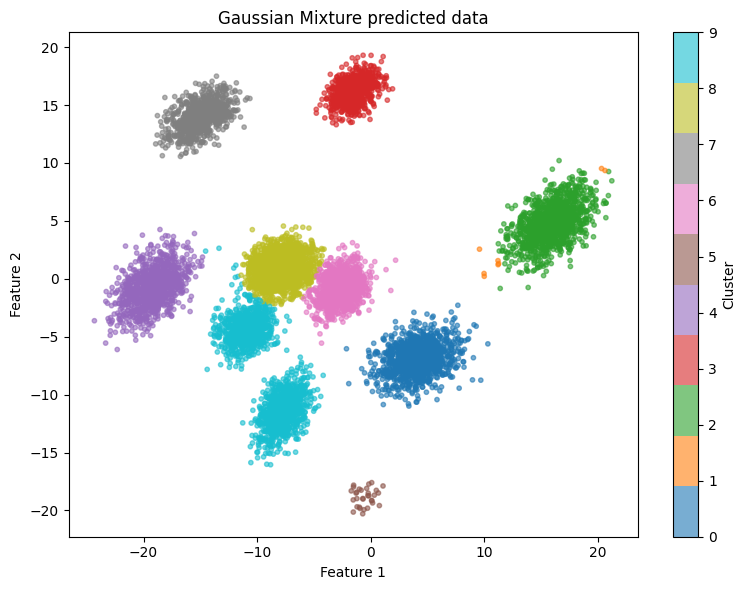

In [36]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', alpha=0.6, s=10)
plt.title("Gaussian Mixture predicted data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, ticks=range(len(phi_true)), label='Cluster')
plt.tight_layout()
plt.show()